In [1]:
import keras
from keras.datasets import mnist
import numpy as np
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, InputLayer, Input
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# data set of dim 28x28 greyscale images
(x_train, _), (x_test, _) = mnist.load_data()

# original dimensions of train & test datasets
x_train.shape, x_test.shape

11493376/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28))

In [3]:
# normalize to range [0,1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape to include channel in dimension
# TODO: change channel to 3 when using RGB images
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # by default uses `channels_last` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Dimensions after including channel info
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [4]:
def add_noise(data, noise_factor = 0.5):
    # add noise
    res = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape) 

    # clip to range
    res = np.clip(res, 0., 1.)
    return res

x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

In [5]:
def sigmoid(x, derivative=False):
    sigm = 1. / (1. + np.exp(-x))
    if derivative:
        return sigm * (1. - sigm)
    return sigm

In [6]:
# KL Divergence regularizer for hidden unit activations
import keras # if using keras
import tensorflow as tf
# from tensorflow import keras # if using tf.keras
kullback_leibler_divergence = keras.losses.kullback_leibler_divergence
K = keras.backend

def kl_divergence_regularizer(activations):
    rho_hat = K.mean(activations, axis=0)
    nprho = np.full((rho_hat.get_shape().as_list()[0],) ,0.05)
    rho = tf.convert_to_tensor(nprho, dtype=tf.float32)
    return 0.01 * (kullback_leibler_divergence(rho, rho_hat)
                 + kullback_leibler_divergence(1 - rho, 1 - rho_hat))

In [7]:
x_train.shape, x_train_noisy.shape, x_test.shape, x_test_noisy.shape

((60000, 28, 28, 1),
 (60000, 28, 28, 1),
 (10000, 28, 28, 1),
 (10000, 28, 28, 1))

In [8]:
# reshape(flatten) so that we can pass to neural network
x_train = x_train.reshape(len(x_train), np.prod(x_train.shape[1:]))
x_train_noisy = x_train_noisy.reshape(len(x_train_noisy), np.prod(x_train_noisy.shape[1:]))

x_test = x_test.reshape(len(x_test), np.prod(x_test.shape[1:]))
x_test_noisy = x_test_noisy.reshape(len(x_test_noisy), np.prod(x_test_noisy.shape[1:]))

# shape after flattening
x_train.shape, x_train_noisy.shape, x_test.shape, x_test_noisy.shape

((60000, 784), (60000, 784), (10000, 784), (10000, 784))

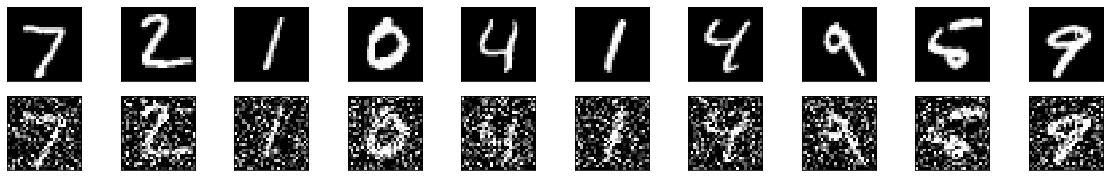

In [9]:
# print first 10 test images
n = 10
plt.figure(figsize=(20, 3))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+10)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

plt.show()

In [10]:
lambdaa = 0.0001
input_layer = Input(shape=(784,))
hidden_layer = Dense(units=2*784, activation='sigmoid', 
                    activity_regularizer=kl_divergence_regularizer,
#                     kernel_regularizer=keras.regularizers.l2(lambdaa)
                    )(input_layer)
output_layer = Dense(units=784, activation='sigmoid',
#                     kernel_regularizer=keras.regularizers.l2(lambdaa)
                    )(hidden_layer)
da1 = Model(input_layer, output_layer)
da1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1568)              1230880   
_________________________________________________________________
dense_2 (Dense)              (None, 784)               1230096   
Total params: 2,460,976
Trainable params: 2,460,976
Non-trainable params: 0
_________________________________________________________________


In [11]:
da1.compile('adam', loss='mse')
da1.fit(x_train_noisy, x_train,
                epochs=50,
                batch_size=120,
                shuffle=True)

Epoch 1/50
60000/60000 [==============================] - 5s 79us/step - loss: 0.1494
Epoch 2/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.0557
Epoch 3/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.0419
Epoch 4/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.0337
Epoch 5/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.0288
Epoch 6/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.0255
Epoch 7/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.0232
Epoch 8/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.0218
Epoch 9/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.0205
Epoch 10/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.0197
Epoch 11/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.0189
Epoch 12/50
60000/60000 [===========================

In [12]:
predicted = da1.predict(x_test_noisy)

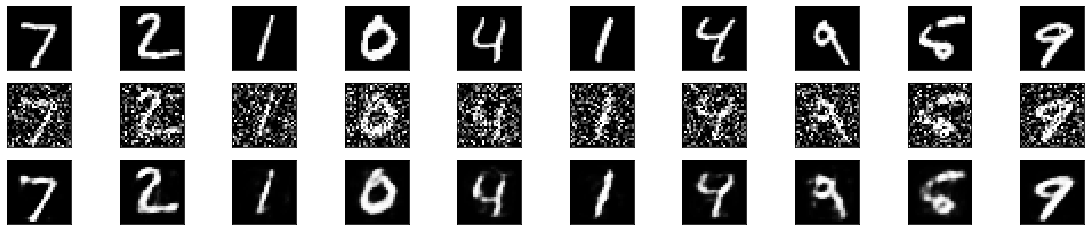

In [13]:
plt.figure(figsize=(40, 4))
for i in range(10):
    # display original images
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display noisy images
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(x_test_noisy[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstructed images
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(predicted[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


plt.show()

In [14]:
import pandas as pd

hiddenLayerWeights = pd.DataFrame(da1.layers[1].get_weights()[0]).values
hiddenLayerBias = pd.DataFrame(da1.layers[1].get_weights()[1]).values
hiddenLayerWeights.shape, type(hiddenLayerWeights), hiddenLayerBias.shape, type(hiddenLayerBias)

Wx = np.dot(x_train_noisy, hiddenLayerWeights)
b =  hiddenLayerBias.T
hX = sigmoid(Wx+b)

Wy = np.dot(x_train, hiddenLayerWeights)
hY = sigmoid(Wy + b)

In [15]:
hX.shape, hY.shape

((60000, 1568), (60000, 1568))

In [16]:
input_layer2 = Input(shape=(2*784,))
hidden_layer2 = Dense(units=2*2*784, activation='sigmoid',
                    activity_regularizer=kl_divergence_regularizer,
#                     kernel_regularizer=keras.regularizers.l2(lambdaa)
                    )(input_layer2)
output_layer2 = Dense(units=2*784, activation='sigmoid',
#                     kernel_regularizer=keras.regularizers.l2(lambdaa)
                    )(hidden_layer2)
da2 = Model(input_layer2, output_layer2)
da2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1568)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              4920384   
_________________________________________________________________
dense_4 (Dense)              (None, 1568)              4918816   
Total params: 9,839,200
Trainable params: 9,839,200
Non-trainable params: 0
_________________________________________________________________


In [17]:
da2.compile(optimizer='adam', loss='mse')
da2.fit(hX, hY,
                epochs=50,
                batch_size=120,
                shuffle=True)

Epoch 1/50
60000/60000 [==============================] - 4s 69us/step - loss: 0.4183
Epoch 2/50
60000/60000 [==============================] - 3s 58us/step - loss: 0.0227
Epoch 3/50
60000/60000 [==============================] - 3s 58us/step - loss: 0.0222
Epoch 4/50
60000/60000 [==============================] - 3s 58us/step - loss: 0.0211
Epoch 5/50
60000/60000 [==============================] - 3s 58us/step - loss: 0.0186
Epoch 6/50
60000/60000 [==============================] - 3s 58us/step - loss: 0.0159
Epoch 7/50
60000/60000 [==============================] - 4s 65us/step - loss: 0.0141
Epoch 8/50
60000/60000 [==============================] - 4s 58us/step - loss: 0.0128
Epoch 9/50
60000/60000 [==============================] - 3s 58us/step - loss: 0.0115
Epoch 10/50
60000/60000 [==============================] - 3s 58us/step - loss: 0.0107
Epoch 11/50
60000/60000 [==============================] - 3s 58us/step - loss: 0.0100
Epoch 12/50
60000/60000 [===========================

In [18]:
# Extract weights
W1, B1 = da1.layers[1].get_weights()
W1_dash, B1_dash = da1.layers[2].get_weights()

W2, B2 = da2.layers[1].get_weights()
W2_dash, B2_dash = da2.layers[2].get_weights()


In [19]:
W1.shape, W2.shape, W2_dash.shape, W1_dash.shape
# B1.shape, B2.shape, B2_dash.shape, B1_dash.shape
# len(B1), len(B2), len(B2_dash), len(B1_dash)

((784, 1568), (1568, 3136), (3136, 1568), (1568, 784))

In [20]:
lambdaa = 0.0001
input_layer = Input(shape=(W1.shape[0],))
h1 = Dense(units=W1.shape[1], activation='sigmoid', 
#                     kernel_regularizer=keras.regularizers.l2(lambdaa)
                    )(input_layer)
h2 = Dense(units=W2.shape[1], activation='sigmoid', 
#                     kernel_regularizer=keras.regularizers.l2(lambdaa)
                    )(h1)
h3 = Dense(units=W2_dash.shape[1], activation='sigmoid', 
#                     kernel_regularizer=keras.regularizers.l2(lambdaa)
                    )(h2)
output_layer = Dense(units=W1_dash.shape[1], activation='sigmoid',
#                     kernel_regularizer=keras.regularizers.l2(lambdaa)
                    )(h3)

dnn = Model(input_layer, output_layer)

# Initialize with pretrained weights
B1 = np.random.uniform(0,1,B1.shape)
B2 = np.random.uniform(0,1,B2.shape)
B1_dash = np.random.uniform(0,1,B1_dash.shape)
B2_dash = np.random.uniform(0,1,B2_dash.shape)

dnn.layers[1].set_weights([W1, B1])
dnn.layers[2].set_weights([W2, B2])
dnn.layers[3].set_weights([W2_dash, B2_dash])
dnn.layers[4].set_weights([W1_dash, B1_dash])

dnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1568)              1230880   
_________________________________________________________________
dense_6 (Dense)              (None, 3136)              4920384   
_________________________________________________________________
dense_7 (Dense)              (None, 1568)              4918816   
_________________________________________________________________
dense_8 (Dense)              (None, 784)               1230096   
Total params: 12,300,176
Trainable params: 12,300,176
Non-trainable params: 0
_________________________________________________________________


In [21]:
# x_sample = x_train[0].reshape(28, 28)
# plt.imshow(x_sample, interpolation='nearest')
# plt.show()

In [22]:
dnn.compile('adam', loss='mse')
dnn.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=120,
                shuffle=True)

Epoch 1/100
60000/60000 [==============================] - 4s 75us/step - loss: 0.0146
Epoch 2/100
60000/60000 [==============================] - 4s 62us/step - loss: 0.0111
Epoch 3/100
60000/60000 [==============================] - 4s 62us/step - loss: 0.0106
Epoch 4/100
60000/60000 [==============================] - 4s 62us/step - loss: 0.0103
Epoch 5/100
60000/60000 [==============================] - 4s 62us/step - loss: 0.0099
Epoch 6/100
60000/60000 [==============================] - 4s 62us/step - loss: 0.0096
Epoch 7/100
60000/60000 [==============================] - 4s 62us/step - loss: 0.0093
Epoch 8/100
60000/60000 [==============================] - 4s 62us/step - loss: 0.0090
Epoch 9/100
60000/60000 [==============================] - 4s 62us/step - loss: 0.0087
Epoch 10/100
60000/60000 [==============================] - 4s 63us/step - loss: 0.0084
Epoch 11/100
60000/60000 [==============================] - 4s 62us/step - loss: 0.0082
Epoch 12/100
60000/60000 [===============

In [23]:
predicted2 = dnn.predict(x_test_noisy)

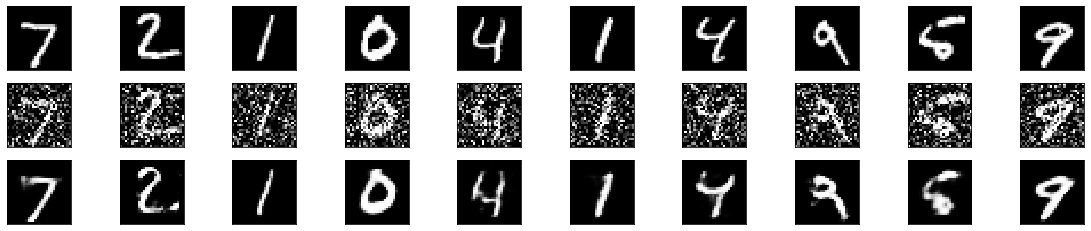

In [24]:
plt.figure(figsize=(40, 4))
for i in range(10):
    # display original images
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display noisy images
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(x_test_noisy[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstructed images
    ax = plt.subplot(3, 20, 2 * 20 + i + 1)
    plt.imshow(predicted2[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
    
plt.show()

In [25]:
# from keras.datasets import mnist
# import numpy as np

# (x_train, _), (x_test, _) = mnist.load_data()

# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
# x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
# x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

# noise_factor = 0.5
# x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
# x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

# x_train_noisy = np.clip(x_train_noisy, 0., 1.)
# x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# n = 10
# plt.figure(figsize=(20, 2))
# for i in range(n):
#     ax = plt.subplot(1, n, i+1)
#     plt.imshow(x_test_noisy[i].reshape(28, 28))
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
# plt.show()